#  Big Data CS649 Project - Part2_Cryptocurrencies tweet sentiments analysis


### Datasets :
- Tweets dataset : https://www.kaggle.com/alaix14/bitcoin-tweets-20160101-to-20190329
    - Contains all the bitcoin tweets
    - date range is from 2016-Jan-01 to 2019-March-29

# Running instruction

#### Packages that needs to be installed before running this notebook. Uncomment below lines once to install it and then comment it again.


In [1]:
# ! pip install -U textblob
# ! pip install google_trans_new

# download english stopwords, this might take little time
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sk105659\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## configurations before running the notebook


In [2]:
import numpy as np 
import pandas as pd


######### Dataset input file path ###########################################################################
# !curl -o tweets.csv https://www.kaggle.com/alaix14/bitcoin-tweets-20160101-to-20190329
# Input dataset which need to downloaded from Kaggle as given above.

bitcoin_tweets_dataset_filepath = './part2_input_dataset/tweets.csv'   
  

################## Number of records to be processed from the dataset input file ###########################
""" This is important as the dataset is very huge and we have many bottleneck services like - 
1) google lan detector
2) google lan translation, 
3) removing english verbose words from tweet text using stopwords from nltk.corpus
4) finding sentiments out of english words using TextBlob """

no_of_records = 99999      # This seems to be a decent number as per our anlysis - output & performance 
# no_of_records = 1000    # To use small dataset for the devlopment purpose


################## filter out dataframe over common date range for both both given datasets - price and tweets ##############
start_date = pd.to_datetime("2017-03-01").date()
end_date = pd.to_datetime("2019-03-29").date()
    
    
######### flag to enable or disable english translation ##########################################################

""" 
detecotor reached to limit after certain hits
if get this error : google_new_transError: 429 (Too Many Requests) from TTS API. 
Then please change below flag from 0 to 1. 
Doing so, it will not convert non-english tweets to english lan and 
therefore the sentiments calucations would not be 100% accurate.

Its a common issue for all free user : https://github.com/lushan88a/google_trans_new/issues/28

we have tried many options like 
giving differnt proxies, making connection using private VPN, 
keep switching the VPN tunnels (specially to Mexico worked) to get the desired ouput for 99999 records.

"""
is_eng_translator_limit_reached = 0   # 0 if limit not recached, 1 if limit reached, 
is_detect_lang_required = 0           # 0 if not required , 1 if required. Turning this off is good as sometime it slows down or reach to thresold limit before the translation itself.


""" Also note, once the translation is done, the output would be saved on the disk 
and so for all the future runs, no translation is required, ranslated data would be read from the saved disk. """

# Name of the file after google translation work is done once. 
processed_bitcoin_tweets_dataset_filepath = './part2_output/tweets_processed_eng_v1.csv'

# This is the path of filename where notebook 1 has already processed bitcoin df and saved to disk
# processed_bitcoin_price_filepath =  './processed_bitcoin.csv'
processed_bitcoin_price_filepath =  './part1_output/processed_bitcoin.csv'

In [3]:
from textblob import TextBlob
import matplotlib.pyplot as plt
from pandas.tseries.offsets import BDay

""" function to read and clean the given dataset """
def read_and_clean_input_file(input_file, no_of_records=no_of_records):
    
    bitcoin_tweets_dataset_df_raw = pd.read_csv(
        input_file, 
        sep=';',
        nrows=no_of_records,
        converters={'text': str},
        usecols=['timestamp', 'text'],                            
        index_col=["timestamp"])
    
    ######### Strip time information from the column 'timestamp' if any  #########
    #  bitcoin_tweets_dataset_df_raw['timestamp'] = pd.to_datetime(bitcoin_tweets_dataset_df_raw['timestamp']).dt.date
    bitcoin_tweets_dataset_df_raw.index = pd.Series(pd.to_datetime(bitcoin_tweets_dataset_df_raw.index)).dt.date
    return bitcoin_tweets_dataset_df_raw


""" function to filter out df over common date range for both both given datasets - price and tweets"""
def filter_by_daterange(df, start_date=start_date, end_date=end_date):
    filtered_date_range = (df.index >= start_date) & (df.index <= end_date)
    df = df[filtered_date_range]
    ### Filter only Business day
    is_business_day = BDay().is_on_offset
    filtered_business_days = pd.to_datetime(df.index).map(is_business_day)
    df[filtered_business_days]
    return df

In [4]:

""" Below function is just for anlysing the datasets """
def analysing_dataset(df):
    display(df)
    #  display(df.info())
    print('shape of dataset is ', df.shape)
    print('min date is ', df.index.min())
    print('max date is ', df.index.max())

########### Testing block #########################################################################################
temp_df = read_and_clean_input_file(bitcoin_tweets_dataset_filepath, no_of_records=10)
analysing_dataset(temp_df)
temp_df = filter_by_daterange(temp_df)
print('\n After filtering out on given date range ')
analysing_dataset(temp_df)

,text
timestamp,
2019-05-27,È appena uscito un nuovo video! LES CRYPTOMONN...
2019-05-27,Cardano: Digitize Currencies; EOS https://t.co...
2019-05-27,Another Test tweet that wasn't caught in the s...
2019-05-27,Current Crypto Prices! \n\nBTC: $8721.99 USD\n...
2019-05-27,Spiv (Nosar Baz): BITCOIN Is An Asset &amp; NO...
2019-05-27,#btc inceldiği yerden kopsun bakalım 17:00 ye ...
2019-05-27,@nwoodfine We have been building on the real #...
2019-05-27,"@pedronauck como investidor, vc é um ótimo dev..."
2019-05-27,ブラジルはまぁ置いといてもドイツは存在感出してくるのかな。ロシアもマイニングなどで元気になる...


shape of dataset is  (10, 1)
min date is  2019-05-27
max date is  2019-05-27

 After filtering out on given date range 


,text
timestamp,


shape of dataset is  (0, 1)
min date is  nan
max date is  nan


In [5]:
from google_trans_new import google_translator  


""" Below function is dedect and translate the non-eng tweets to eng tweets """
# translator = google_translator()
# translator = google_translator(url_suffix="hk",timeout=5,proxies={'https':'206.189.44.99:8080','http':'96.9.77.203:55667'})
translator = google_translator(timeout=40)
detector = google_translator()  

def add_english_translated_tweets_to_df(df):
    english_translated_col = []
    df['text'] = df['text'].astype(str)
    for tweet in df['text']:
        if len(tweet)!=0:
            if is_detect_lang_required == 1 :
                detect_lang = detector.detect(tweet)
                if (detect_lang != ['en', 'english']) :
                    english_translated_col.append(translatoror.translate(tweet,lang_tgt='en') )
                else:
                    english_translated_col.append(tweet)
            else:
                english_translated_col.append(translator.translate(tweet,lang_tgt='en') )
        else:
            english_translated_col.append(None)

    df['english_translated'] = english_translated_col
    return df


############  Testing block  ##############################################################################
#### function to detect lan  ################################
text1 = "Another text which is already in english, so should not be translated."
text2 = "È appena uscito un nuovo video! LES CRYPTOMONN..."
detect_lang = detector.detect(text2)
print(detect_lang)

#### function to translate the text to english ################
if (detect_lang != ['en', 'english']) :
    print(translator.translate(text2,lang_tgt='en') )
else:
    print(text2)

['it', 'italian']
A new video has just come out! Les Cryptomonn ... 


In [6]:

""" function for reading, cleaning, filtering over date range, and writing the output to the disk """
def read_clean_filter_translate_write_file(input_file, no_of_records=no_of_records):
    bitcoin_tweets_dataset_df_cleaned = read_and_clean_input_file(input_file, no_of_records)
    bitcoin_tweets_dataset_df_cleaned = filter_by_daterange(bitcoin_tweets_dataset_df_cleaned)
    
    if(is_eng_translator_limit_reached != 1):
        bitcoin_tweets_dataset_df_cleaned = add_english_translated_tweets_to_df(bitcoin_tweets_dataset_df_cleaned)
    else:        
        bitcoin_tweets_dataset_df_cleaned['english_translated'] = bitcoin_tweets_dataset_df_cleaned['text']

    ##### Write the processed ouput to disk. This is to avoid unnecssary english translation everytime we run the program
    # The seperator delimeter of orginal file is ';' but for processed file it is ','. This should be good across complete file
    bitcoin_tweets_dataset_df_cleaned.to_csv(index=True, sep=',' , path_or_buf=processed_bitcoin_tweets_dataset_filepath)
    return bitcoin_tweets_dataset_df_cleaned

# Main function of the program

In [7]:
import os.path
from os import path

""" This is the main block of our program. 
This would check whether it has already processed file, if so simply read from there instead of executing it again """
def main():
    if path.exists(processed_bitcoin_tweets_dataset_filepath):
        print ("processed bitcoin_tweets dataset filep exist")
    else:
        print ("processed bitcoin_tweets dataset file does not exist")
        read_clean_filter_translate_write_file(bitcoin_tweets_dataset_filepath)
        
    processed_bitcoin_tweets_dataset_df = pd.read_csv(
        processed_bitcoin_tweets_dataset_filepath, 
        sep=',',
        dtype= {'text': str, 'english_translated': str},
        # dtype= str,
        # converters={'english_translated': str},
        index_col=["timestamp"])

    # Strip time information from the column 'timestamp' if any
    # processed_bitcoin_tweets_dataset_df['timestamp'] = pd.to_datetime(processed_bitcoin_tweets_dataset_df['timestamp']).dt.date
    processed_bitcoin_tweets_dataset_df.index = pd.Series(pd.to_datetime(processed_bitcoin_tweets_dataset_df.index)).dt.date
    print(processed_bitcoin_tweets_dataset_df.shape)
    return processed_bitcoin_tweets_dataset_df

processed_bitcoin_tweets_dataset_df = main()

# Filter the dates between a range which is common to both dataframes - tweets dataframe and price dataframe
# processed_bitcoin_tweets_dataset_df = filter_by_daterange(processed_bitcoin_tweets_dataset_df)

# processed_bitcoin_tweets_dataset_df = processed_bitcoin_tweets_dataset_df.sort_index()   -- no need to sort. that is just for verification and display purpose, if needed.


############  Testing block  ##############################################################################
display(processed_bitcoin_tweets_dataset_df.sample(10))
print('min date is ',processed_bitcoin_tweets_dataset_df.index.min())
print('max date is ',processed_bitcoin_tweets_dataset_df.index.max())


processed bitcoin_tweets dataset filep exist
(2014, 2)


,text,english_translated
timestamp,,
2019-03-07,XCh4NGE lets you decide your exposure to trans...,XCh4NGE lets you decide your exposure to trans...
2019-02-21,Top 5 #cryptocurrencies \n Alert Time: 2019-02...,Top 5 #cryptocurrencies \n Alert Time: 2019-02...
2018-09-18,#cryptocurrency Price Analysis for #Bitsend #B...,#cryptocurrency Price Analysis for #Bitsend #B...
2018-03-11,Ecex Exchange ICO https://ecex.exchange \nCurr...,Ecex Exchange ICO https://ecex.exchange \nCurr...
2018-10-20,El lunes a las 00:30h en #Millennium ¿Cómo nac...,Monday at 00: 30h in #millennium How is born a...
2018-05-16,"05/17 02:00現在(Zaif調べ)\n\n#Bitcoin : 916,000円↓0...",05/17 02:00 Current (ZAIF check) #Bitcoin: 91...
2018-09-01,#BTCUSD Market #1H timeframe on September 1 a...,#BTCUSD Market #1H timeframe on September 1 a...
2018-07-18,"Bitcoin 31 Aralığa kadar 20.000 $ geçerse, bu ...","If Bitcoin passes $ 20,000 up to 31 gap, I giv..."
2019-02-18,"Together with @nadiaheninger, just presented o...","Together with @nadiaheninger, just presented o..."


min date is  2017-05-24
max date is  2019-03-29


In [8]:
import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')

""" Utility function to clean tweet text by removing special characters and links using regex"""
def clean_special_chars(text):
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+://\S+)", " ", text).split())


""" Utility function to clean tweet text and remove verbose english words using nltk stopwords"""
def clean_and_remove_english_verbose_words(text):
    text = clean_special_chars(text)
    forbidden_words = set(stopwords.words('english'))
    text = ' '.join(text.split('.'))
    text = re.sub('\/',' ',text)
    text = text.strip('\'"')
    text = re.sub(r'@([^\s]+)',r'\1',text)
    text = re.sub(r'\\',' ',text)
    text = text.lower()
    text = re.sub('[\s]+', ' ', text)
    text = re.sub(r'#([^\s]+)', r'\1', text)
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',text)
    text = re.sub(r'((http)\S+)','',text)
    text = re.sub(r'\s+', ' ', re.sub('[^A-Za-z]', ' ', text.strip().lower())).strip()
    text = re.sub(r'\W+', ' ', text.strip().lower()).strip()
    text = [word for word in text.split() if word not in forbidden_words]
    return ' '.join(text)


""" Utility function to classify sentiment of passed tweet using textblob's sentiment method """
def sentiment(text):
    # create TextBlob object of passed tweet text
    text_analysis = TextBlob(text)
    return text_analysis.sentiment.polarity



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sk105659\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
from textblob import TextBlob

""" Utility function to classify sentiment of passed tweet using textblob's sentiment method """
def add_eng_keywords_and_sentiments(df):
    english_keywords_col = []
    sentiment_col = []
    for tweet in df['english_translated']:
        
        # If running stopwords on big data slows donw the speed, then we can skip stopwords logic for performance and only use the simple cleaning of special chars
        english_keywords = clean_and_remove_english_verbose_words(tweet)
        #   english_keywords = clean_special_chars(tweet)
        english_keywords_col.append(english_keywords)
        
        # Add corresponding sentiments
        sentiment_polarity = sentiment(tweet)
        sentiment_col.append(sentiment_polarity)
    
    df['english_keywords'] = english_keywords_col
    df['sentiment'] = sentiment_col
    return df

processed_bitcoin_tweets_dataset_df = add_eng_keywords_and_sentiments(processed_bitcoin_tweets_dataset_df)


# Considering minimum sentiment of the day.
#  Note : played with first, max, min, mean. i think mean is the best one for this.
bitcoin_tweets_sentiment_df = processed_bitcoin_tweets_dataset_df.groupby(processed_bitcoin_tweets_dataset_df.index).min()
bitcoin_tweets_sentiment_df.sample(10)
bitcoin_tweets_sentiment_df

,text,english_translated,english_keywords,sentiment
timestamp,,,,
2017-05-24,So @Bitcoin just broke $2400.00 ea thanks to J...,So @Bitcoin just broke $2400.00 ea thanks to J...,broke ea thanks japan legislation good day enc...,0.450000
2017-05-25,#Bitcoin #thatBitcoinlife will provide everyth...,#Bitcoin #thatBitcoinlife will provide everyth...,bitcoin thatbitcoinlife provide everything tho...,0.000000
2017-06-06,New all time #bitstamp #bitcoin high of $2787.00,New all time #bitstamp #bitcoin high of $2787.00,new time bitstamp bitcoin high,0.148182
2017-06-22,"JNECare: wprameswari_15 Hi kak, admin cek kiri...","JNE Care: PRAMESWARI 15 HI Sis, Admin Checks t...",jne care prameswari hi sis admin checks shipme...,0.000000
2017-06-30,historic btc price on July 4th\n2016: +6.00% \...,historic btc price on July 4th\n2016: +6.00% \...,historic btc price july th,0.000000
...,...,...,...,...
2019-03-25,Oh shit! Still time to buy $btc for lunch in 1...,Oh shit! Still time to buy $btc for lunch in 1...,oh shit still time buy btc lunch min every day...,-0.250000
2019-03-26,"₿1 = $3,951 (00:56 UTC)\n$BTC prices rise!\n#...",#cryptocurrency Price Analysis for #Bitsend #B...,bittrex volume changed globalcoin btc glc pric...,-0.500000
2019-03-27,#BTT در @Coinsuper_OFCL در دسترس است، شما میتو...,#BTT was listed in @CoInSuper_OFCL. #BTT can b...,bittrex volume changed bitstarcoin btc bits pr...,0.000000


# Referring to part1 notebook for already proccessed bitcoin price dataset

In [10]:
######## Part1 notebook is writing processed output to a file and this part 2 is reading the same file #################
# %store -r big_frame
# display(big_frame)
# bitcoin_price_df = big_frame.query("coin_name == 'Bitcoin'")
# bitcoin_price_df.to_csv(index=False, sep=',' , path_or_buf=processed_bitcoin_price_filepath)
# display(bitcoin_price_df)


""" function to read and filter over the date range. 
This date range is common to both dataframes - tweets dataframe and price dataframe """
def read_and_filter_bitcoin_price_file():
    bitcoin_price_df = pd.read_csv(processed_bitcoin_price_filepath, sep=',')
    bitcoin_price_df['Date'] = pd.to_datetime(bitcoin_price_df['Date']).dt.date
    bitcoin_price_df = bitcoin_price_df.set_index(['Date'])
    display(bitcoin_price_df)

    # Filter over date range. 
    bitcoin_price_df = filter_by_daterange(bitcoin_price_df)
    # bitcoin_price_df = bitcoin_price_df['Price'].to_frame()
    bitcoin_price_df = bitcoin_price_df[['Price', 'Change']]
    return bitcoin_price_df

bitcoin_price_df = read_and_filter_bitcoin_price_file()
display(bitcoin_price_df)

,Price,Open,High,Low,Volume,Change,coin_name_abbrv,coin_name,Volume_in_Million
Date,,,,,,,,,
2021-04-25,49561.9,50088.2,50438.8,49226.5,66.26K,-1.05%,Bit,Bitcoin,0.06626
2021-04-24,50088.9,51140.8,51183.0,48775.2,82.25K,-2.06%,Bit,Bitcoin,0.08225
2021-04-23,51143.6,51707.1,52099.9,47659.4,214.46K,-1.13%,Bit,Bitcoin,0.21446
2021-04-22,51729.5,53821.3,55408.4,50590.9,168.13K,-3.88%,Bit,Bitcoin,0.16813
2021-04-21,53820.2,56479.5,56764.4,53657.6,100.26K,-4.71%,Bit,Bitcoin,0.10026
...,...,...,...,...,...,...,...,...,...
2010-07-22,0.1,0.1,0.1,0.1,2.16K,0.00%,Bit,Bitcoin,0.00216
2010-07-21,0.1,0.1,0.1,0.1,0.58K,0.00%,Bit,Bitcoin,0.00058
2010-07-20,0.1,0.1,0.1,0.1,0.26K,0.00%,Bit,Bitcoin,0.00026


,Price,Change
Date,,
2019-03-29,4102.2,1.90%
2019-03-28,4025.6,-0.40%
2019-03-27,4041.7,2.51%
2019-03-26,3942.8,0.15%
2019-03-25,3937.0,-1.44%
...,...,...
2017-03-05,1271.2,0.55%
2017-03-04,1264.3,-1.48%
2017-03-03,1283.3,2.22%


In [11]:
""" function to merge two dataframes based on common date range """
def merge_bitcoin_price_and_tweets_data(bitcoin_price_df, bitcoin_tweets_sentiment_df):
    df = pd.merge(bitcoin_price_df, bitcoin_tweets_sentiment_df, left_index=True, right_index=True, how='inner')
    return df

""" function to add  'Sentiment categorical' column """
def make_sentiment_column_categorical(bitcoin_price_sentiment):
    bitcoin_price_sentiment['sentiment_cat'] = bitcoin_price_sentiment['sentiment'].astype('category')
    bitcoin_price_sentiment['sentiment_cat'] = bitcoin_price_sentiment['sentiment_cat'].cat.codes
    return bitcoin_price_sentiment

bitcoin_price_sentiment  = merge_bitcoin_price_and_tweets_data(bitcoin_price_df, bitcoin_tweets_sentiment_df)
bitcoin_price_sentiment['sentiment_scaled'] = bitcoin_price_sentiment['sentiment'] * 10000
bitcoin_price_sentiment = make_sentiment_column_categorical(bitcoin_price_sentiment)
bitcoin_price_sentiment

,Price,Change,text,english_translated,english_keywords,sentiment,sentiment_scaled,sentiment_cat
2019-03-29,4102.2,1.90%,"₿1 = $4,136 (00:28 UTC)\n$BTC prices continue...",#cryptocurrency Price Analysis for #Bitsend #B...,bittrex volume changed counterparty btc xcp pr...,-0.221212,-2212.121212,17
2019-03-28,4025.6,-0.40%,And we deserved it :)\n\n#agrocoin #LATOKEN #a...,And we deserved it :)\n\n#agrocoin #LATOKEN #a...,bittrex volume changed folding coin btc fldc p...,0.000000,0.000000,50
2019-03-27,4041.7,2.51%,#BTT در @Coinsuper_OFCL در دسترس است، شما میتو...,#BTT was listed in @CoInSuper_OFCL. #BTT can b...,bittrex volume changed bitstarcoin btc bits pr...,0.000000,0.000000,50
2019-03-26,3942.8,0.15%,"₿1 = $3,951 (00:56 UTC)\n$BTC prices rise!\n#...",#cryptocurrency Price Analysis for #Bitsend #B...,bittrex volume changed globalcoin btc glc pric...,-0.500000,-5000.000000,4
2019-03-25,3937.0,-1.44%,Oh shit! Still time to buy $btc for lunch in 1...,Oh shit! Still time to buy $btc for lunch in 1...,oh shit still time buy btc lunch min every day...,-0.250000,-2500.000000,15
...,...,...,...,...,...,...,...,...
2017-06-30,2480.6,-3.04%,historic btc price on July 4th\n2016: +6.00% \...,historic btc price on July 4th\n2016: +6.00% \...,historic btc price july th,0.000000,0.000000,50
2017-06-22,2722.8,1.69%,"JNECare: wprameswari_15 Hi kak, admin cek kiri...","JNE Care: PRAMESWARI 15 HI Sis, Admin Checks t...",jne care prameswari hi sis admin checks shipme...,0.000000,0.000000,50
2017-06-06,2870.5,6.12%,New all time #bitstamp #bitcoin high of $2787.00,New all time #bitstamp #bitcoin high of $2787.00,new time bitstamp bitcoin high,0.148182,1481.818182,59
2017-05-25,2307.2,-5.65%,#Bitcoin #thatBitcoinlife will provide everyth...,#Bitcoin #thatBitcoinlife will provide everyth...,bitcoin thatbitcoinlife provide everything tho...,0.000000,0.000000,50


In [12]:
import matplotlib.pyplot as plt

""" function to plot line  """
def plot_one_line(line1, label1=None, title='', color='blue', xlabel=None, ylabel=None, legend_loc='best', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw, color=color)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc=legend_loc, fontsize=16)
    
""" function to plot two lines in one figuare  """
def plot_two_lines(line1, line2, label1=None, label2=None, title='', xlabel=None, ylabel=None, legend_loc='best', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc=legend_loc, fontsize=16)

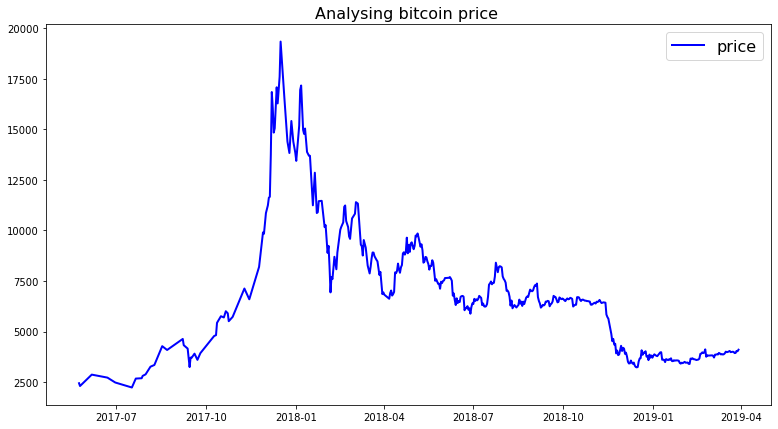

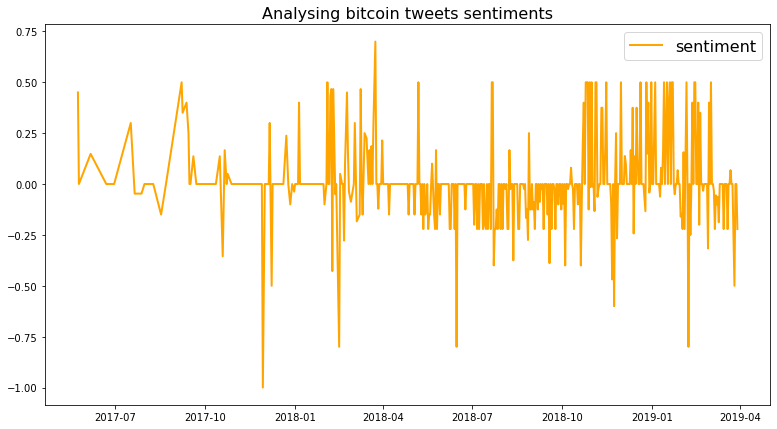

In [13]:
plot_one_line(bitcoin_price_sentiment['Price'], 'price', title='Analysing bitcoin price ', color ='blue')
plot_one_line(bitcoin_price_sentiment['sentiment'] , 'sentiment', title='Analysing bitcoin tweets sentiments', color = 'orange')
# plot_one_line(bitcoin_price_sentiment['sentiment_scaled'] , 'sentiment_scaled', title='Analysing tweets sentiments', color = 'orange')
# plot_one_line(bitcoin_price_sentiment['sentiment_cat'] , 'sentiment_cat', title='Analysing tweets sentiments', color = 'orange')

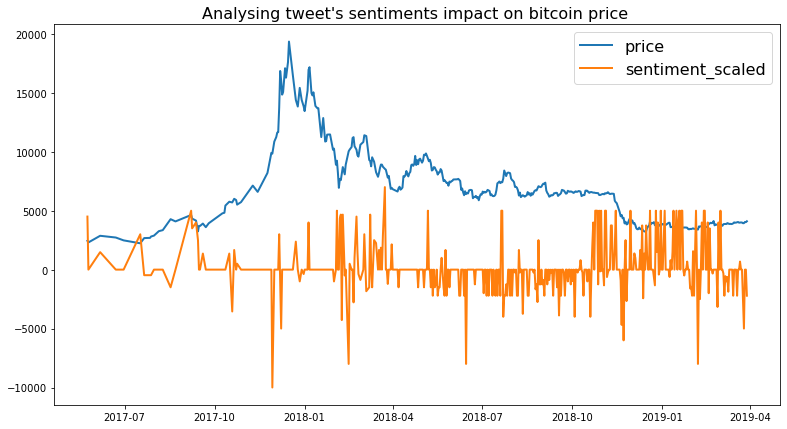

In [14]:
plot_two_lines(bitcoin_price_sentiment['Price'], bitcoin_price_sentiment['sentiment_scaled'], 'price', 'sentiment_scaled', title='Analysing tweet\'s sentiments impact on bitcoin price ')

In [15]:
# bitcoin_price_sentiment

""" function to find sentiment nature (positive, negative or neutral) from sentiment polarity """
def get_tweet_sentiment_nature(tweet_polarity):
    # set sentiment
    if tweet_polarity > 0:
        return 'positive'
    elif tweet_polarity == 0:
        return 'neutral'
    else:
        return 'negative'
    
bitcoin_price_sentiment['sentiment_nature'] = bitcoin_price_sentiment['sentiment'].apply(lambda tweet_polarity: get_tweet_sentiment_nature(tweet_polarity))    
bitcoin_price_sentiment

,Price,Change,text,english_translated,english_keywords,sentiment,sentiment_scaled,sentiment_cat,sentiment_nature
2019-03-29,4102.2,1.90%,"₿1 = $4,136 (00:28 UTC)\n$BTC prices continue...",#cryptocurrency Price Analysis for #Bitsend #B...,bittrex volume changed counterparty btc xcp pr...,-0.221212,-2212.121212,17,negative
2019-03-28,4025.6,-0.40%,And we deserved it :)\n\n#agrocoin #LATOKEN #a...,And we deserved it :)\n\n#agrocoin #LATOKEN #a...,bittrex volume changed folding coin btc fldc p...,0.000000,0.000000,50,neutral
2019-03-27,4041.7,2.51%,#BTT در @Coinsuper_OFCL در دسترس است، شما میتو...,#BTT was listed in @CoInSuper_OFCL. #BTT can b...,bittrex volume changed bitstarcoin btc bits pr...,0.000000,0.000000,50,neutral
2019-03-26,3942.8,0.15%,"₿1 = $3,951 (00:56 UTC)\n$BTC prices rise!\n#...",#cryptocurrency Price Analysis for #Bitsend #B...,bittrex volume changed globalcoin btc glc pric...,-0.500000,-5000.000000,4,negative
2019-03-25,3937.0,-1.44%,Oh shit! Still time to buy $btc for lunch in 1...,Oh shit! Still time to buy $btc for lunch in 1...,oh shit still time buy btc lunch min every day...,-0.250000,-2500.000000,15,negative
...,...,...,...,...,...,...,...,...,...
2017-06-30,2480.6,-3.04%,historic btc price on July 4th\n2016: +6.00% \...,historic btc price on July 4th\n2016: +6.00% \...,historic btc price july th,0.000000,0.000000,50,neutral
2017-06-22,2722.8,1.69%,"JNECare: wprameswari_15 Hi kak, admin cek kiri...","JNE Care: PRAMESWARI 15 HI Sis, Admin Checks t...",jne care prameswari hi sis admin checks shipme...,0.000000,0.000000,50,neutral
2017-06-06,2870.5,6.12%,New all time #bitstamp #bitcoin high of $2787.00,New all time #bitstamp #bitcoin high of $2787.00,new time bitstamp bitcoin high,0.148182,1481.818182,59,positive
2017-05-25,2307.2,-5.65%,#Bitcoin #thatBitcoinlife will provide everyth...,#Bitcoin #thatBitcoinlife will provide everyth...,bitcoin thatbitcoinlife provide everything tho...,0.000000,0.000000,50,neutral


In [16]:
print("\n Cleaned tweets count = ", bitcoin_tweets_sentiment_df.sentiment.count())
print("\n Cleaned bitcoin_price count = ", bitcoin_price_df.Price.count())
print("\n Cleaned merged df count = ", bitcoin_price_sentiment.Price.count())

# bitcoin_price_sentiment
analysis = bitcoin_price_sentiment.drop(columns=['Price','text', 'english_translated', 'english_keywords', 'sentiment_scaled'])
# analysis = bitcoin_price_sentiment.drop(columns=['Price', 'sentiment_scaled', 'sentiment_cat_scaled'])
analysis['Change'] = analysis['Change'].str.replace('%', '').astype(float)
display(analysis)
# display(analysis.info())


 Cleaned tweets count =  463

 Cleaned bitcoin_price count =  759

 Cleaned merged df count =  463


,Change,sentiment,sentiment_cat,sentiment_nature
2019-03-29,1.90,-0.221212,17,negative
2019-03-28,-0.40,0.000000,50,neutral
2019-03-27,2.51,0.000000,50,neutral
2019-03-26,0.15,-0.500000,4,negative
2019-03-25,-1.44,-0.250000,15,negative
...,...,...,...,...
2017-06-30,-3.04,0.000000,50,neutral
2017-06-22,1.69,0.000000,50,neutral
2017-06-06,6.12,0.148182,59,positive
2017-05-25,-5.65,0.000000,50,neutral


In [17]:
grouped_sentiment_price_change = analysis.groupby(['sentiment_nature'], as_index=False)
mean_bitcoin_price_change = grouped_sentiment_price_change.mean()
print("\nMean of bitcoin price change per sentiment")
print(mean_bitcoin_price_change)


stddev_bitcoin_price_change = grouped_sentiment_price_change['Change'].apply(lambda x: x.std())
print("\nStddev of bitcoin price change per sentiment")
print(stddev_bitcoin_price_change)


Mean of bitcoin price change per sentiment
  sentiment_nature    Change  sentiment  sentiment_cat
0         negative  0.329683  -0.194557      23.746032
1          neutral  0.016255   0.000000      50.000000
2         positive  0.392209   0.334011      72.732558

Stddev of bitcoin price change per sentiment
  sentiment_nature    Change
0         negative  3.806280
1          neutral  4.145568
2         positive  5.089519


<AxesSubplot:xlabel='sentiment_nature', ylabel='Change'>

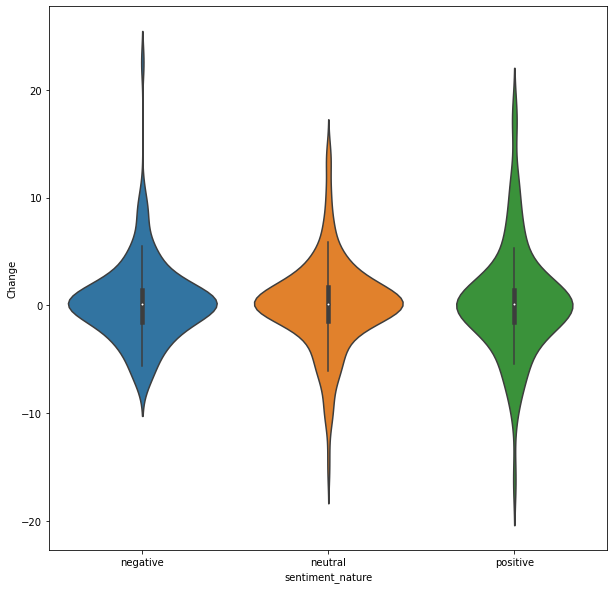

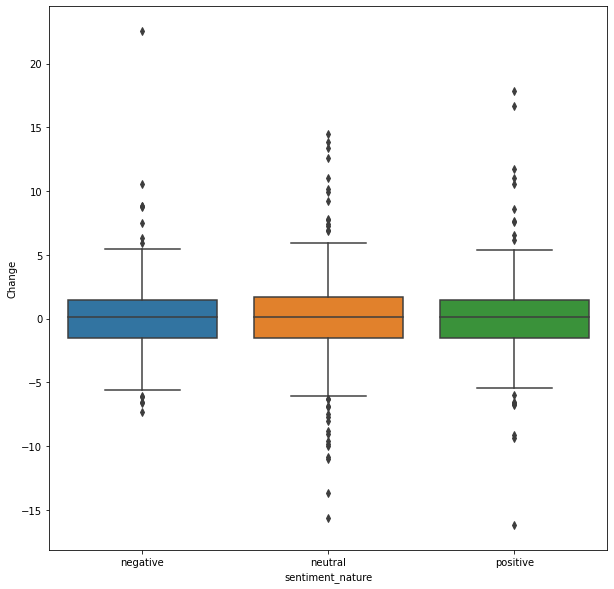

In [18]:
import seaborn as sns
plt.figure(figsize=(10, 10))
sns.violinplot(x=analysis.sentiment_nature, y=analysis.Change, data=analysis, height=8)


plt.figure(figsize=(10, 10))
sns.boxplot(data=analysis, x=analysis.sentiment_nature, y=analysis.Change)

<AxesSubplot:>

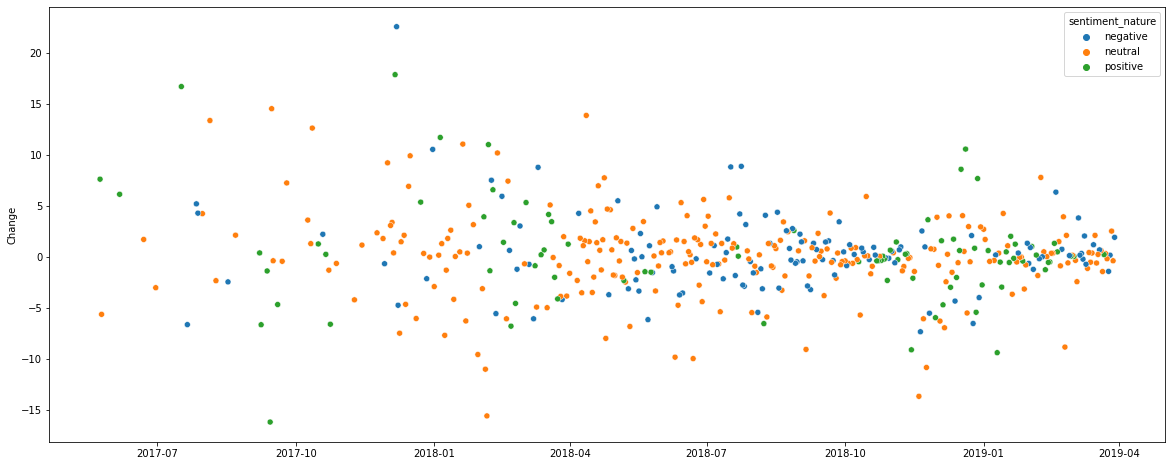

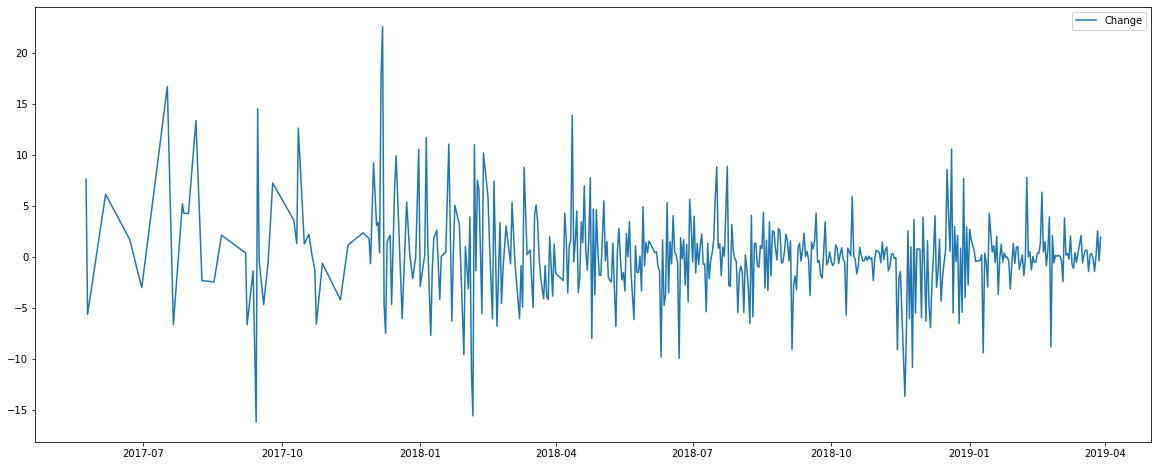

In [19]:
plt.figure(figsize=(20, 8))
sns.scatterplot(x=analysis.index, y=analysis['Change'], data=analysis, hue=analysis['sentiment_nature']);
analysis[['Change']].plot(figsize=(20, 8))

## Conclusion : 
 - Positive sentiments - “happy” reads as a positive Tweet. However, in our case it could be the words “buy” or “long” or “hold,” none of which would read positive using normal sentiment analysis.
 - Also with cryptocurrency it’s hard to generalize anything.
